In [1]:
import main
import math
import random
import tikzplotlib
import timeit
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import patches, cm, colors
from scipy.spatial import distance
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

Multiple runs with different $\Delta a = {0.5, 0.1, 0.05}$

In [2]:
def draw_state(file_name, variable="energy"):
    ## let's have fun with colours --> map energy values to color palette
    my_palette = LinearSegmentedColormap.from_list('custom red', ["#577590", "#f94144", "#f8961e"], N=256)
    # my_palette = LinearSegmentedColormap.from_list('custom red', ["#ffffff", "#ff0a54"], N=256)

    if variable == "energy": 
        ## heatmap of energy
        # minima = np.round(np.min(Energy), 2)
        minima = 0
        # maxima = np.round(np.max(Energy), 2)
        maxima = 2.6
    
    elif variable == "coord_number":
        ## heatmap of coordination number
        minima = np.round(np.min(coord_number), 2)
        maxima = np.round(np.max(coord_number), 2)
    
    norm = colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=my_palette)

    plt.figure(figsize=(8,8))

    ## dimensions for patches
    a_width, b_height = 2*new_dist.a, 2*new_dist.b

    for center in new_dist.ell:
        index = np.where(new_dist.ell == center)
        
        if variable == "energy":
            v = Energy[-1,index]

        elif variable == "coord_number":
            v = coord_number[-1,index]

        ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
        plt.gca().add_patch(ellipse)
        ellipse.set_facecolor(mapper.to_rgba(v)[0])
        ellipse.set_label('_nolegend_')

    cbar = np.round( np.linspace(minima, maxima, 5, endpoint=True), 2)
    plt.colorbar(mapper, ticks=cbar, shrink=0.85, orientation='vertical')

    plt.axis('scaled')
    plt.xlim(0.0, width)
    plt.ylim(0.0, height)
    plt.savefig(file_name, bbox_inches='tight')
    plt.close()

In [3]:
grid = [100, 100]
width, height = grid
m, N = 2, 128                   #  number of starting points and number of all points

## Selects two random points on a grid
initial = np.array( [[random.uniform(0,1)*width, random.uniform(0,1)*height] for i in range(m)] )
## and and generate distribution with Mitchell algorithm
dist = main.distribution(initial, grid, N)

## change circles into ellipses
a0, b0 = 5, 2                       # big and small semi-axis
eps = math.sqrt(1 - (b0/a0)**2)     # eccentricity
a_width, b_height = 2*a0, 2*b0      # values for matplotlib.pathces

In [4]:
## average over multiple runs
multiple_runs_energy, multiple_runs_coord, multiple_runs_accepted, multiple_runs_rejected, multiple_runs_correlation = [], [], [], [], []
times = []
i = 1

________________

In [5]:
new_dist = main.ellipses(dist, a0, b0)

## distance matrix between all the centres
S = [x.center for x in new_dist.ell]
distance_matrix = distance.cdist(S, S, dist.periodic_metric)

In [7]:
start_time = timeit.default_timer()
## let's do a run till a size that is surely stuck

# i = 0                                         ## counter for gifs
delta_a = 0.1                                   ## select growth step
#a_range = a0 + np.linspace(0,30,31)*delta_a
a_range = [a0]
save_energy, save_coord, save_accepted, save_rejected, save_correlation = [], [], [], [], []
r = np.linspace(1,3,100)

for a in a_range:
    b = a*math.sqrt(1-eps**2)
    new_dist.a = a
    new_dist.b = b

    a_width, b_height = 2*a, 2*b

    ## update a in matrices A
    new_dist.fix_A

    ## distance matrix between all the centres
    S = [x.center for x in new_dist.ell]
    distance_matrix = distance.cdist(S, S, dist.periodic_metric)
    
    ## matrix of indices of neighbouring ellipses, which are less than 2*a apart
    in_proximity = [np.where((line<=2*new_dist.a) & (line!=0)) for line in distance_matrix]

    ## find new state
    Energy, coord_number, accepted, rejected = new_dist.metropolis(in_proximity, n=1000)

    ## save variables
    save_energy.append(Energy[-1])
    save_coord.append(coord_number[-1])
    save_accepted.append(accepted)
    save_rejected.append(rejected)
    save_correlation.append(new_dist.angle_correlation(r*new_dist.a))

    # output_name = "../figures/gifs/delta_a_05/pic" + f"{i:02d}.png"
    # draw_state(output_name)
    # i += 1

elapsed = timeit.default_timer() - start_time
times.append(elapsed)

In [319]:
output_name = "../figures/runs/delta_a_005/run" + f"{i:02d}.png"
draw_state(output_name)
i += 1

/tmp/ipykernel_27964/3755150052.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mapper, ticks=cbar, shrink=0.85, orientation='vertical')


In [320]:
multiple_runs_energy.append(save_energy)
multiple_runs_coord.append(save_coord)
multiple_runs_accepted.append(save_accepted)
multiple_runs_rejected.append(save_rejected)
multiple_runs_correlation.append(save_correlation)

display(np.asarray(multiple_runs_energy).shape)

(10, 61, 128)

In [336]:
display(np.average(times)/60, np.std(times)/60)

50.58345794100023

2.569020307815978

Energy and error

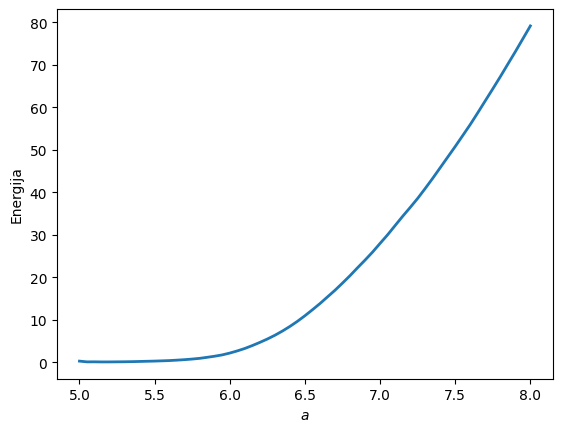

In [330]:
## Energy
all_energy = 0.5*np.sum(multiple_runs_energy, axis=2)
energy_deviation = np.std(all_energy, axis=0)
all_energy = np.average(all_energy, axis=0)

x = a_range
y = all_energy

np.savetxt("../gnuplot/a_005_energy.txt", np.c_[a_range, all_energy, energy_deviation], 
            header = "a, energy, energy deviation", delimiter='\t')
 
plt.plot(x,y,linewidth=2)
plt.xlabel("$a$")
plt.ylabel("Energija")
plt.show()
# tikzplotlib.save("test.tex")

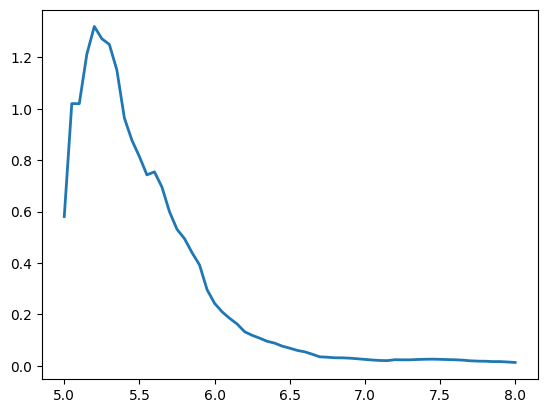

In [323]:
x = a_range
y = energy_deviation/all_energy

plt.plot(x,y,linewidth=2)
plt.show()

Average number of contacts per an ellipse

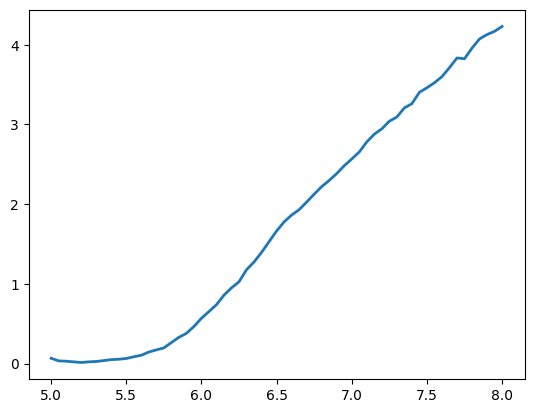

In [331]:
## Coordination number
all_coord = np.average(multiple_runs_coord, axis=2)
coord_deviation = np.std(all_coord, axis=0)
all_coord = np.average(all_coord, axis=0)

x = a_range
y = all_coord

np.savetxt("../gnuplot/a_005_coord_number.txt", np.c_[a_range, all_coord, coord_deviation], 
            header = "a, coordination nubmer, coordination nubmer deviation", delimiter='\t')

plt.plot(x,y,linewidth=2)
plt.show()

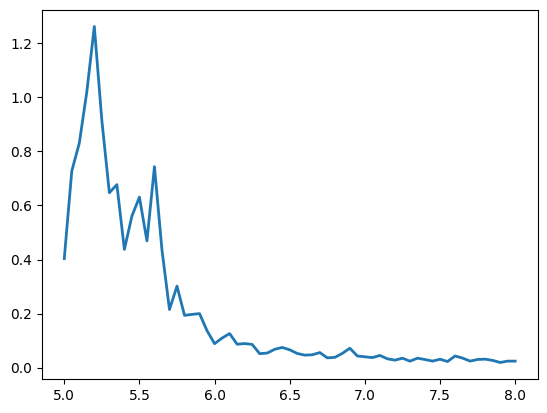

In [325]:
x = a_range
y = coord_deviation/all_coord

plt.plot(x,y,linewidth=2)
plt.show()

Orientational correlation function

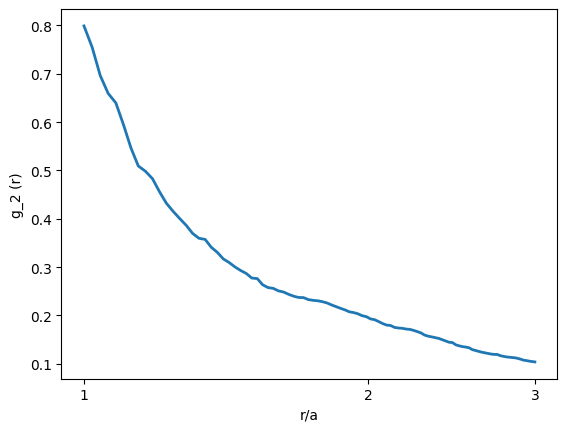

In [332]:
## Orientational correlation
corr_deviation = np.std(multiple_runs_correlation, axis=0)[-1,:]
all_correlation = np.average(multiple_runs_correlation, axis=0)[-1,:]

r = np.linspace(1, 3, 100)
y = all_correlation

plt.plot(r, y, linewidth=2)

plt.xscale('log')
plt.xticks([1, 2, 3], [1, 2, 3])

np.savetxt("../gnuplot/a_005_correlation.txt", np.c_[r, all_correlation, corr_deviation], 
            header = "r, orientational correlation, deviation", delimiter='\t')

plt.xlabel('r/a')
plt.ylabel('g_2 (r)')
plt.show()

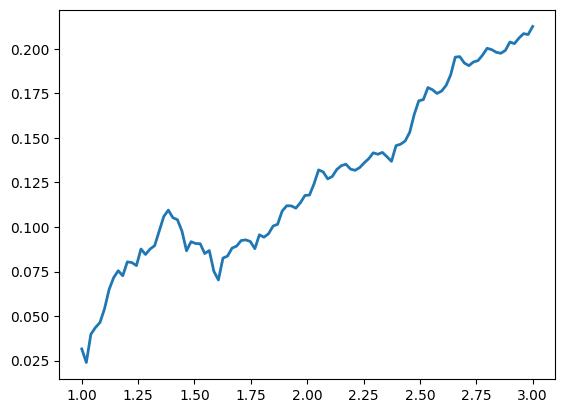

In [327]:
r = np.linspace(1, 3, 100)
y = corr_deviation/all_correlation

plt.plot(r,y,linewidth=2)
plt.show()

Number of accepted and rejected rotations

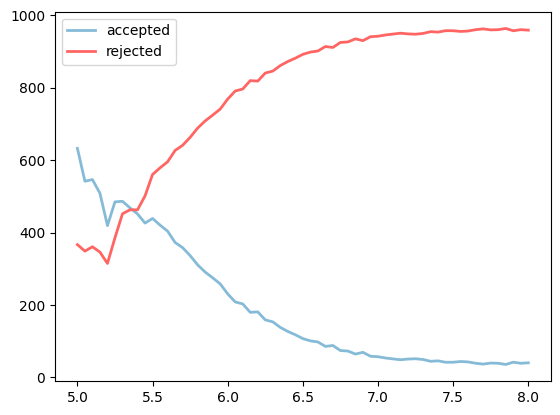

In [333]:
## Accepted and rejected
my_array = np.asarray(multiple_runs_accepted)
all_accepted = [[len(my_array[j,i,:][~np.isnan(my_array[j,i,:])]) for i in range(len(my_array[0,:,0]))]
                for j in range(len(my_array[:,0,:])) ]
accepted_deviation = np.std(all_accepted, axis=0)
all_accepted = np.average(all_accepted, axis=0)

my_array = np.asarray(multiple_runs_rejected)
all_rejected = [[len(my_array[j,i,:][~np.isnan(my_array[j,i,:])]) for i in range(len(my_array[0,:,0]))]
                for j in range(len(my_array[:,0,:])) ]
rejected_deviation = np.std(all_rejected, axis=0)
all_rejected = np.average(all_rejected, axis=0)

x = a_range
y = all_accepted
z = all_rejected

np.savetxt("../gnuplot/a_005_rotation.txt", np.c_[a_range, all_accepted, accepted_deviation, all_rejected, rejected_deviation], 
            header = "a, accepted rotations, accepted deviation, rejected rotations, rejected deviation", delimiter='\t')

plt.plot(x, y, color='#86BBD8', linewidth=2, label='accepted')
plt.plot(x, z, color='#FF6663', linewidth=2, label='rejected')
plt.legend(loc='upper left')
plt.show()

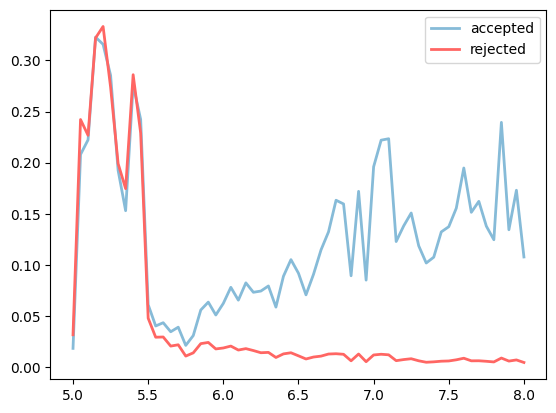

In [329]:

x = a_range
y = accepted_deviation/all_accepted
z = rejected_deviation/all_rejected

plt.plot(x, y, color='#86BBD8', linewidth=2, label='accepted')
plt.plot(x, z, color='#FF6663', linewidth=2, label='rejected')
plt.legend(loc='upper right')
plt.show()